# Introduction to Yelp Review Sentiment Classification

In this project, we will build a classifier that can predict a user's rating of a given restaurant from their review. In doing so, we will explore the broader topic of sentiment analysis, that is, being able to quantify an individual's opinion about a particular topic merely from the words they use. Nowadays, sentiment analysis is used widely by companies in order to better understand their user's preferences and tastes.




![Example of a Yelp review](https://wordstream-files-prod.s3.amazonaws.com/s3fs-public/styles/simple_image/public/images/yelp-reviews-filtered.png)

In [ ]:
#@title Import our libraries (this may take a minute or two)
import pandas as pd   # Great for tables (google spreadsheets, microsoft excel, csv). 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import nltk
import spacy
import wordcloud
import os # Good for navigating your computer's files 
import sys

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from spacy.lang.en.stop_words import STOP_WORDS
nltk.download('wordnet')
nltk.download('punkt')

from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
!python -m spacy download en_core_web_md
import en_core_web_md



[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
     |████████████████████████████████| 96.4 MB 1.2 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_md')


In [ ]:
#@title Import our data

import gdown
gdown.download('https://drive.google.com/uc?id=1u0tnEF2Q1a7H_gUEH-ZB3ATx02w8dF4p', 'yelp_final.csv', True)
data_file  = 'yelp_final.csv'


## Data Exploration

First we read in the file containing the reviews and take a look at the data available to us.

In [ ]:
# read our data in using 'pd.read_csv('file')'
yelp = pd.read_csv(data_file)

In [ ]:
yelp

,business_id,stars,text,user_id,cool,useful,funny
0,9yKzy9PApeiPPOUJEtnvkg,5,My wife took me here on my birthday for breakf...,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0
1,ZRJwVLyzEJq1VAihDhYiow,5,I have no idea why some people give bad review...,0a2KyEL0d3Yb1V6aivbIuQ,0,0,0
2,_1QQZuf4zZOyFCvXc0o6Vg,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",uZetl9T0NcROGOyFfughhg,1,2,0
3,6ozycU1RpktNG2-1BroVtw,5,General Manager Scott Petello is a good egg!!!...,vYmM4KTsC8ZfQBg-j5MWkw,0,0,0
4,zp713qNhx8d9KCJJnrw1xA,5,Drop what you're doing and drive here. After I...,wFweIWhv2fREZV_dYkz_1g,7,7,4
...,...,...,...,...,...,...,...
995,-fsCfTYEnJ4s6yStgBnQig,1,If it wasn't for the bad food I would go here ...,3XyuBpNbvrHukaEJyWBAsw,0,0,0
996,_ISHH8x8Qe6IoVTQWegbpQ,1,This was absolutely horrible. I got the suprem...,DRw2GfcyTo8wjx2G27NxlQ,1,2,0
997,AqbgC7Gul5Es1rRzGNLDFA,1,Yeah...notsomuch.\n\nSprinkles is sooooooooo n...,g84VjttN28PWiv_WtdhnSQ,17,20,30
998,QxEUzbLfCTXF6gHWJegWgw,1,I (like others) am at a loss as to why this pl...,d1vSOBq_RauHGpCh7VN7KA,0,0,0


In [ ]:
#@title Show data
yelp.head()

,business_id,stars,text,user_id,cool,useful,funny
0,9yKzy9PApeiPPOUJEtnvkg,5,My wife took me here on my birthday for breakf...,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0
1,ZRJwVLyzEJq1VAihDhYiow,5,I have no idea why some people give bad review...,0a2KyEL0d3Yb1V6aivbIuQ,0,0,0
2,_1QQZuf4zZOyFCvXc0o6Vg,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",uZetl9T0NcROGOyFfughhg,1,2,0
3,6ozycU1RpktNG2-1BroVtw,5,General Manager Scott Petello is a good egg!!!...,vYmM4KTsC8ZfQBg-j5MWkw,0,0,0
4,zp713qNhx8d9KCJJnrw1xA,5,Drop what you're doing and drive here. After I...,wFweIWhv2fREZV_dYkz_1g,7,7,4


We have access to 7 columns of data. For our purposes the business_id and user_id information are not important. Also as you can see the data in these columns do not really correspond to business names or user names. They are random strings, generated by a process called hashing to anonymize the users and businesses.

What is *hashing*? We do not need to go in depth about this as it is a concept from computer science unrelated to machine learning. It is a way of *encrypting* data using some predefined function, that maps any kind of data to a random string of a defined length. You can read more about it [here](https://medium.com/tech-tales/what-is-hashing-6edba0ebfa67). 




In [ ]:
#@title **Run to remove unnecessary columns** { display-mode: "form" }
yelp.drop(labels=['business_id','user_id'],inplace=True,axis=1)

The text column is the one we are primarily focused with. Let's take a look at a few of these reviews to better understand our problem.

In [ ]:
#@title Check the text in differently rated reviews
num_stars = 2 #@param {type:"integer"}

for t in yelp[yelp['stars'] == num_stars]['text'].head(20).values:
    print (t) 

Was it worth the 21$ for a salad and small pizza? Absolutely not! Bad service. Maybe the guys grandma died I don't know. I want to tell you what really made me mad about the experience. We order the small pizza and salad and the guys could have cared less and took our $ and we sat down. We were looking around and hmm, there's a sign saying "x large pizza and large salad only 23$". Wow that would have been nice if the guy told us that. I left hungry, mad and unsatisfied. 

To the owner: teach your employees the value of upselling and telling the specials. Something so small can affect a customers experience negatively. 

And your salads are severely overpriced 

Won't go back unless I'm desperate.
I have to add to Andrew's review.....

I just can't believe the things that happened!!

Yes the app was good.  The entree was good too, but there were bites of just bread with no chicken in the panini.  It definitely would have been better with more chicken!

But the girl working here is one o

We can start to see that there are certain quantitative differences between highly rated reviews and poorly rated reviews. Certain words, for example, 'delightful', 'impressive', 'amazing', might be more associated with 4 or 5 star reviews. However one might be able to see that these words might also be present in a 2 star review. For example: "The seating and ambience were impressive, but the food served to us was not". 


### **Exercise 1**

Can you think of any combinations of words, or rules, that would indicate how many stars a given review corresponds to? Note them down below:




In [ ]:
#@title Rules
rule_1 = "" #@param {type:"string"}
rule_2 = "" #@param {type:"string"}
rule_3 = "" #@param {type:"string"}

It is not really the presence of individual words that gives us an indication of the stars given to a review, but more  the *relative occurrence* of these words in each review that might give us an indication of a user's rating. If this does not make sense immediately, do not worry, we will come back to this concept later. 


#### Word Clouds

Another way to take a look at the most prominent words in any given star rating is through the use of word clouds. 

Edit the value in the cell below to see the word cloud for each star rating.

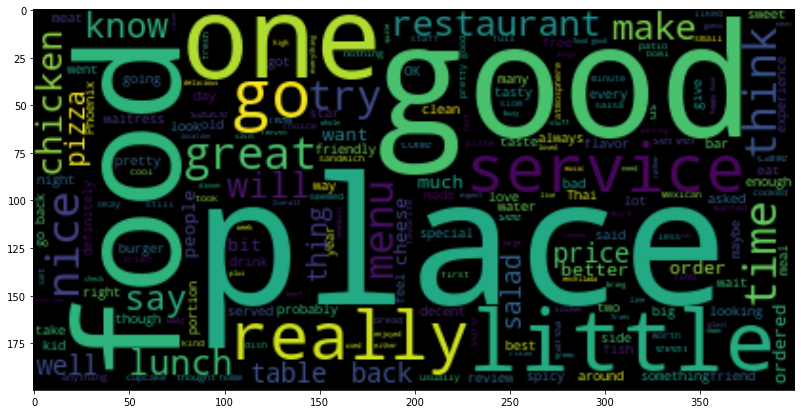

In [ ]:
#@title Word cloud for differently rated reviews
num_stars = 3 #@param {type:"integer"}
this_star_text = ''
for t in yelp[yelp['stars'] == num_stars]['text'].values: # form field cell
    this_star_text += t + ' '
    
wordcloud = WordCloud()    
wordcloud.generate_from_text(this_star_text)
plt.figure(figsize=(14,7))
plt.imshow(wordcloud, interpolation='bilinear')

**What are the differences between the reviews that have 1, 2, 3, 4, and 5 stars?**

*As* we can see, in this case, the word cloud does not give us a great deal of distinguishing information between reviews that have 1, 2, 3, 4, or 5 stars. All these reviews seem to prominently feature words such as 'place', 'food', 'service' and 'table'. Human intuition will only get us so far. 

Before we go any further, we will need to clean up our text.

## Text Preprocessing

#### Tokenization

First of all, we would like to convert each review from a single string into a list of words (this is a process known as tokenizaton). All NLP algorithms require a list of words as arguments and not actual sentences. Enter some example text into the cell below to see the tokenized version.

In [ ]:
#@title Basic tokenization example
example_text = "j'onn j'onzz is cool" #@param {type:"string"}
tokens = word_tokenize(example_text)
tokens

["j'onn", "j'onzz", 'is', 'cool']

#### Stopwords

We can see that certain particular words might be associated with 4 or 5 star reviews, and some words would be associated with 1 or 2 star reviews. However, at the same time, there are some words that do not really possess any relevant information for our current problem. In the field of NLP there is a concept of words that are "stopwords" - words that exist to provide grammatical structure, but do not convey information about the particular subject. Edit the cell below to see if a given word is a stop word.

In [ ]:
#@title Check if a word is a stop word
example_word = "m*t**********" #@param {type:'string'}
if example_word.lower() in STOP_WORDS:
  print (example_word + " is a stop word.")
else:
  print (example_word + " is NOT a stop word.")

m*t********** is NOT a stop word.


We would like to remove these stopwords from the user reviews.

Tokenization and removal of stop words are universal to nearly every NLP application. In some cases, additional cleaning may be required (for example, removal of proper nouns, removal of digits) but we can build a text preprocessing function with these "base" cleaning steps.

Putting all these together, we can come up with a text cleaning function that we can apply to all of our reviews.

Apply the text cleaning function on an example text to see if it works properly. 

# Intro to Spacy


Now a library we are going to use is Spacy.

Spacy, like the other Python libraries, gives us a lot of useful functions that we can directly use.

Unlike the other libraries, spacy does a lot more. It gives us insights into the English Language (actually, you can use many other languages here). The way it does is it downloads a set of information about the English Language and lets you use it.

`
nlp = spacy.load('en_core_web_sm')
`

Now when you call any sentence with this nlp object you will get quite a few helper functions that are really useful for a lot of tasks.

Lets explore some of the things that Spacy provides.


In [ ]:
nlp = en_core_web_md.load()
doc = nlp(u"We are running out of time! Are we though?")
doc


We are running out of time! Are we though?

The doc object has a lot of nice properties. For instance you can get the text of each of the words and the length of each of the words.

In [ ]:
# doc = nlp(u"We are running out of time! Are we though?")
token = doc[0] # Get the first word in the text.
assert token.text == u"We" # Check that the token text is 'We'.
assert len(token) == 2 # Check that the length of the token is 2.

In [ ]:
tokens = nlp("I didn't love the food")
for i, t in enumerate(tokens):
  print(str(i) + ": " + t.text)

0: I
1: did
2: n't
3: love
4: the
5: food


It has some word vectors that we can use. Though note that it doesn't have all the words. Let's import a new dataset of word (this may take a minute or so):

We can get the word embedding of a particular word in our document as follows:

In [ ]:
doc = nlp(u"I like apples")
apples = doc[2]
print(apples.vector)
print(apples.vector.shape) # Each word is being represented by 300 dimensional vector embedding

[-0.6334     0.18981   -0.53544   -0.52658   -0.30001    0.30559
 -0.49303    0.14636    0.012273   0.96802    0.0040354  0.25234
 -0.29864   -0.014646  -0.24905   -0.67125   -0.053366   0.59426
 -0.068034   0.10315    0.66759    0.024617  -0.37548    0.52557
  0.054449  -0.36748   -0.28013    0.090898  -0.025687  -0.5947
 -0.24269    0.28603    0.686      0.29737    0.30422    0.69032
  0.042784   0.023701  -0.57165    0.70581   -0.20813   -0.03204
 -0.12494   -0.42933    0.31271    0.30352    0.09421   -0.15493
  0.071356   0.15022   -0.41792    0.066394  -0.034546  -0.45772
  0.57177   -0.82755   -0.27885    0.71801   -0.12425    0.18551
  0.41342   -0.53997    0.55864   -0.015805  -0.1074    -0.29981
 -0.17271    0.27066    0.043996   0.60107   -0.353      0.6831
  0.20703    0.12068    0.24852   -0.15605    0.25812    0.007004
 -0.10741   -0.097053   0.085628   0.096307   0.20857   -0.23338
 -0.077905  -0.030906   1.0494     0.55368   -0.10703    0.052234
  0.43407   -0.13926    0

The word 'Apple' is represented by a 300 dimensional vector embedding


### Fun things you can do with word vectors

### Exercise 2

You can get the similarity of two words via the following method:


```
doc = nlp(u"keyboard and mouse")
word1 = doc[0]
word2 = doc[2]
word1.similarity(word2)
```

**Use the above methodology to find two words with a similarity greater than 0.77 and two words with similarity less than 0.15. Share both of your word pairings with the class.**


In [ ]:
### YOUR CODE HERE
doc = nlp(u"red blue")
word1 = doc[0]
word2 = doc[1]
word1.similarity(word2)
### END CODE

0.8438412

As we saw before, the language in 4 star reviews is quite similar to the language in 5 star reviews. So the text in those reviews might not be very useful and we can drop those rows from our data.

Although the text in the 3 star reviews is not very similar to the 1 or 2 star reviews, it is quite different from the language used in the 5 star reviews. So we could actually group those reviews together with the 1 and 2 star reviews.

In order to reduce our problem to a **binary classification** problem, we will:

 - remove all 4 star reviews
 - label 5 star reviews as 'good'
 - label 1, 2, 3 star reviews as 'bad'

Run the cell below to get rid of 4 star reviews.

In [ ]:
yelp = yelp[yelp.stars != 4]

### Exercise 3

Complete the second line of code in the cell below, and run it to re-categorize our reviews. 

In [ ]:
def is_good_review(stars):
    if stars == 5:  ### TODO: FILL IN THE IF STATEMENT HERE ###:
        return True
    else:
        return False

# Change the stars field to either be 'good' or 'bad'.
yelp['is_good_review'] = yelp['stars'].apply(is_good_review)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


## One-Hot Vectors

How do we convert our text to numbers in a structured way that we can feed into a machine learning algorithm? One way to do it is to use a concept called "one-hot encoding". We can see this concept with the following example. Suppose we have a sentence "great tacos at this restaurant". Its one-hot encoding would be.

In [ ]:
#@title Run this to see the one-hot encoding of 'great tacos at this restaurant'
print('{:^5}|{:^5}|{:^4}|{:^4}|{:^10}'.format('great', 'tacos', 'at','this','restaurant'))
print('--------------------------------------------')
print('{:^5}|{:^5}|{:^4}|{:^4}|{:^10}'.format('1', '0', '0','0','0'))
print('{:^5}|{:^5}|{:^4}|{:^4}|{:^10}'.format('0', '1', '0','0','0'))
print('{:^5}|{:^5}|{:^4}|{:^4}|{:^10}'.format('0', '0', '1','0','0'))
print('{:^5}|{:^5}|{:^4}|{:^4}|{:^10}'.format('0', '0', '0','1','0'))
print('{:^5}|{:^5}|{:^4}|{:^4}|{:^10}'.format('0', '0', '0','0','1'))

great|tacos| at |this|restaurant
--------------------------------------------
  1  |  0  | 0  | 0  |    0     
  0  |  1  | 0  | 0  |    0     
  0  |  0  | 1  | 0  |    0     
  0  |  0  | 0  | 1  |    0     
  0  |  0  | 0  | 0  |    1     


###Exercise: One Hot Encoding - Sentences

Let's say you just have two reviews(vocabulary) as following:

1. I loved the restaurant
2. I hate the food 

The vocabulary would consist of unique words across both the reviews. Now create one-hot encoded vector for reviews above.

## Bag of Words

Building upon the concept of one-hot encoding is the **bag of words** model. If one-hot encoding is a way to represent individual words as vectors, then you can think of bag of words as a way to represent sentences (or larger pieces of text) as the **sum** of the one-hot encoding vectors of each of the words. Let's explain with an example. 

Suppose we want to represent the review: 
**"The food was great. The ambience was also great."** as a bag of words.

First we define our vocabulary. This is *each unique word* in the review. So our vocabulary is **[the, food, was, great, ambience, also]**.

What are our one hot encodings? 

the = (1,0,0,0,0,0)

food = (0,1,0,0,0,0)

was = (0,0,1,0,0,0)

great = (0,0,0,1,0,0)

ambience = (0,0,0,0,1,0)

also = (0,0,0,0,0,1).

So far, so simple. Now how do we represent the review we mentioned above as a bag of words? We know we only have 6 words in our vocabulary, so our bag of words vector will also only be 6 elements long. To construct it, we can start off with a (0,0,0,0,0,0) vector, and then pass through each word in the review. For each word we encounter, we simply add its one hot encoding to our vector! So for our review, the bag of words representation will be

**(2,1,2,2,1,1)**

## Creating our Bag of Words

Back to our data. We want to select the features for our model and the output classes from our data. What are the features? We are only using the review text to make predictions for our model. And the output classes are the 'good' and 'bad' review classes we created just above. 

By convention, we represent our entire set of features as X, and our target output as y. Running the cell below will create the relevant X and y for our problem.

In [ ]:
X = yelp['text']
y = yelp['is_good_review']

In [ ]:
X.shape, y.shape

((646,), (646,))

In [ ]:
X, y

(0      My wife took me here on my birthday for breakf...
 1      I have no idea why some people give bad review...
 2      Rosie, Dakota, and I LOVE Chaparral Dog Park!!...
 3      General Manager Scott Petello is a good egg!!!...
 4      Drop what you're doing and drive here. After I...
                              ...                        
 995    If it wasn't for the bad food I would go here ...
 996    This was absolutely horrible. I got the suprem...
 997    Yeah...notsomuch.\n\nSprinkles is sooooooooo n...
 998    I (like others) am at a loss as to why this pl...
 999    When I was in highschool various clubs used to...
 Name: text, Length: 646, dtype: object, 0       True
 1       True
 2       True
 3       True
 4       True
        ...  
 995    False
 996    False
 997    False
 998    False
 999    False
 Name: is_good_review, Length: 646, dtype: bool)

Running the cell below will create an object we can use to *transform* each piece of raw text into a bag of words vector.
CountVectorizer is a useful class we can call from scikit-learn that will help us create this object. It even has a helpful parameter that we can set to our tokenize function to preprocess the raw text.

In [ ]:
#@title Initialize the text cleaning function { display-mode: "form" }
def tokenize(text):
    clean_tokens = []
    for token in nlp(text):
        if (not token.is_stop) & (token.lemma_ != '-PRON-') & (not token.is_punct): # -PRON- is a special all inclusive "lemma" spaCy uses for any pronoun, we want to exclude these 
            clean_tokens.append(token.lemma_)
    return clean_tokens

In [ ]:
bow_transformer = CountVectorizer(analyzer=tokenize, max_features=1000).fit(X)

We can see our entire vocabulary by running the cell below! You will also notice an index associated with each word - this is the position of each word in the vocabulary.

In [ ]:
bow_transformer.vocabulary_

{'wife': 975,
 'take': 881,
 'birthday': 151,
 'breakfast': 170,
 'excellent': 355,
 ' ': 2,
 'perfect': 661,
 'sit': 810,
 'outside': 637,
 'waitress': 956,
 'food': 398,
 'arrive': 104,
 'quickly': 720,
 'busy': 183,
 'Saturday': 59,
 'morning': 592,
 'look': 539,
 'like': 525,
 'place': 675,
 'fill': 383,
 'pretty': 701,
 'well': 972,
 '\n\n': 1,
 'simply': 807,
 'good': 426,
 'sure': 874,
 'use': 939,
 'ingredient': 490,
 'fresh': 403,
 'order': 635,
 'amazing': 89,
 'menu': 572,
 'white': 974,
 'egg': 339,
 'vegetable': 945,
 'tasty': 886,
 'delicious': 291,
 'come': 234,
 '2': 13,
 'piece': 673,
 'bread': 168,
 'absolutely': 76,
 'meal': 565,
 'toast': 904,
 'wait': 954,
 'idea': 481,
 'people': 659,
 'bad': 125,
 'review': 750,
 'go': 425,
 'probably': 706,
 'case': 194,
 'friend': 404,
 'past': 654,
 'Sunday': 65,
 'crowded': 267,
 'think': 898,
 'evening': 352,
 'seat': 780,
 'say': 776,
 'girl': 420,
 'seating': 781,
 'waiter': 955,
 'get': 417,
 'drink': 326,
 'pleasant': 68

We can see the length of the vocabulary stored in the transformer object by running the cell below. 

In [ ]:
len(bow_transformer.vocabulary_)

1000

Finally, to finish preparing our data, we can use the transformer to transform our entire training set (X) into a series of bag of words vectors:

In [ ]:
X = bow_transformer.transform(X)
print(X.toarray())

[[ 0  3  8 ...  0  0  0]
 [ 0  2  1 ...  0  0  0]
 [ 0  2  1 ...  0  0  0]
 ...
 [ 0 11  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 3  0  3 ...  0  0  0]]


## Training a Baseline Classification Model (Logistic Regression)

Our classification problem is a classic two-class classification problem, and so we will use the tried and tested **Logistic Regression** machine learning model from yesterday's class.

In [ ]:
# import the logistic regression model from scikit-learn
logistic_model = LogisticRegression()

We will use 20% of our data as test data. If you run the cell below, it will randomly split the data such that 80% of it is training data and 20% of it is data we can use to test the predictions from our trained model.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

### **Exercise 4**
Now that we have our model selected and our data split, let's train our model. Refer to yesterday's logistic regression notebook for a remainder about how to train the model.

In [ ]:
### YOUR CODE HERE
logistic_model.fit(X_train, y_train)
### END CODE

LogisticRegression()

## Exercise 5

Once the model is trained, we can generate predictions from our test data. Just like the fit() function above, there is a similar predict() function that we can use once our model is trained. Create your model's predictions on the text model. Next, use the true positive (TP), false positive (FP), true negative (TN), and false negative (FN) rates to evaluate the accuracy of the model.

In [ ]:
### YOUR CODE HERE

preds = logistic_model.predict(X_test)

# Get the confusion matrix.
cm = confusion_matrix(y_test, preds)

# Get TP, FP, TN, and FN rates.
TP = cm[0][0]
TN = cm[1][1]
FP = cm[0][1]
FN = cm[1][0]

accuracy =  (TP + TN) / (TP + FP + TN + FN)

print("The accuracy of the model is " + str(accuracy*100) + "%")

### END CODE

The accuracy of the model is 76.15384615384615%


In [ ]:
#@title Enter an example review, and see if it is classified as good or bad
example_review = "" #@param {type:'string'}
prediction = logistic_model.predict(bow_transformer.transform([example_review]))

if prediction:
  print ("This was a GOOD review!")
else:
  print ("This was a BAD review!")



This was a BAD review!


###Exercise 6


Now change the max features attribute while creating your bag of words model. Discuss how the change affects the accuracy of the model

###Exercise 7 (Optional)
We used Logistic regression for our baseline model. However we could also use a separate model called Multinomial Naive Bayes to perform our classification.
Naive Bayes uses Bayes' Theorem of probability to predict class of new input data. The important assumption Naive Bayes makes is that the presence of one feature is independent of the presence of any other.

Let's build a model using a Naive Bayes classifier!

In [ ]:
from sklearn.naive_bayes import GaussianNB
nb_model = GaussianNB()

We can train and generate predictions from this model in the same way we did for our Logisitic Regression model. Try training this model on the same data and see if it performs better or worse than our logistic regression model. Then, evaluate the model accuracy as your did for the Logistic Regression classifier.



In [ ]:
###YOUR CODE HERE####
nb_model.fit(X_train.toarray(), y_train)

GaussianNB()

Experiment with the models you've learned so far and try to get the highest accuracy!

In [ ]:
###YOUR CODE BELOW###

preds = nb_model.predict(X_test.toarray())

# Get the confusion matrix.
cm = confusion_matrix(y_test, preds)

# Get TP, FP, TN, and FN rates.
TP = cm[0][0]
TN = cm[1][1]
FP = cm[0][1]
FN = cm[1][0]

accuracy =  (TP + TN) / (TP + FP + TN + FN)

print("The accuracy of the model is " + str(accuracy*100) + "%")


The accuracy of the model is 63.07692307692307%


In [ ]:
#@title Enter an example review, and see if it is classified as good or bad
example_review = "Gross" #@param {type:'string'}
prediction = nb_model.predict(bow_transformer.transform([example_review]).toarray())

if prediction:
  print ("This was a GOOD review!")
else:
  print ("This was a BAD review!")



This was a GOOD review!


### Exercise 8

We saw earlier that our WordClouds didn't give us too much useful information. What words were present across all kinds of reviews? If we take those words out of the reviews, we could possibly have more useful WordClouds.

Identify some of these common words and add them to the list in the cell below. Then, run the word cloud to see the words that show up across review types.


In [ ]:
###Fill in the list with the words you think which should be removed. Ex: ['food','time','service']###
common_words = ['food', 'place', 'restaurant', 'one', 'service', 'time', 'good', 'really']

In [ ]:
#@title Word cloud for differently rated reviews
num_stars = 4 #@param {type:"integer"}
this_star_text = ''
for t in yelp[yelp['stars'] == num_stars]['text'].values: # form field cell
    this_star_text += t + ' '
    for word in common_words:
      this_star_text = this_star_text.replace(word,'')
    
wordcloud = WordCloud()    
wordcloud.generate_from_text(this_star_text)
plt.figure(figsize=(14,7))
plt.imshow(wordcloud, interpolation='bilinear')

ValueError: ignored

### (Optional Advanced Exercise) Training Logistic Regression with Word Vectors from Spacy

We can use the word vectors we introduced earlier to get more sophisticated representations of our Yelp reviews. First, we get the text data from our dataframe:

In [ ]:
X_data = yelp['text']
y_data = yelp['is_good_review']
print(X_data)

0      My wife took me here on my birthday for breakf...
1      I have no idea why some people give bad review...
2      Rosie, Dakota, and I LOVE Chaparral Dog Park!!...
3      General Manager Scott Petello is a good egg!!!...
4      Drop what you're doing and drive here. After I...
                             ...                        
995    If it wasn't for the bad food I would go here ...
996    This was absolutely horrible. I got the suprem...
997    Yeah...notsomuch.\n\nSprinkles is sooooooooo n...
998    I (like others) am at a loss as to why this pl...
999    When I was in highschool various clubs used to...
Name: text, Length: 646, dtype: object


This helper function uses the Spacy `nlp` object to remove stop words, pronouns, and punctuation. It is identical to the `tokenize` function above, except it preserves the non-string attributes of the clean tokens (i.e. `token.vector`)

In [ ]:
def tokenize_vecs(text):
    clean_tokens = []
    for token in nlp(text):
        if (not token.is_stop) & (token.lemma_ != '-PRON-') & (not token.is_punct) & (str(token) not in common_words): 
          # -PRON- is a special all inclusive "lemma" spaCy uses for any pronoun, we want to exclude these 
            clean_tokens.append(token)
    return clean_tokens

We want to represent each Yelp review with a vector. Since each review consists of multiple words, we want to find a way to create one vector for each review. 

Would adding the word vectors work? What about averaging? Which would be preferrable?

Implement your solution below: convert our array of reviews into an array of vector representations of those reviews.

In [ ]:
X_word2vec = []
for text in X_data:
  review = tokenize_vecs(text) # returns cleaned list of spacy tokens

  sum_ = 0
  #### YOUR CODE HERE
  for t in review:
    sum_ += t.vector
  X_word2vec.append(sum_ / len(review))
  #### END CODE
  
X_word2vec = np.array(X_word2vec)
print(X_word2vec)

[[-0.03894394  0.0672079  -0.00282954 ... -0.16245852  0.05994515
   0.04839403]
 [-0.11621041  0.1485964  -0.03662864 ... -0.14397879  0.09709776
   0.10686696]
 [ 0.1846425   0.08784518 -0.15734749 ... -0.06132792  0.00354624
   0.05250753]
 ...
 [-0.13073692  0.03925245 -0.10752786 ... -0.00782176  0.06856176
   0.05669905]
 [-0.43486834  0.35830033 -0.10993334 ... -0.14032184  0.20133816
   0.04235584]
 [-0.1260912   0.10476233 -0.04356375 ... -0.1023097   0.04314388
   0.15589543]]


Now we follow the same procedure for training and testing the logistic regression that we used for the Bag of Words data.

In [ ]:
# import a fresh logistic regression model from scikit-learn
logistic_model = LogisticRegression()

In [ ]:
# train-test split
X_train_word2vec, X_test_word2vec, y_train_word2vec, y_test_word2vec = train_test_split(X_word2vec, y, test_size=0.2, random_state=101)

In [ ]:
logistic_model.fit(X_train_word2vec, y_train_word2vec)

LogisticRegression()

In [ ]:
#@title Run this to print the accuracy for our word2vec classifier


# Get our predictions.
preds = logistic_model.predict(X_test_word2vec)

# Get the confusion matrix.
cm = confusion_matrix(y_test_word2vec, preds)

# Get TP, FP, TN, and FN rates.
TP = cm[0][0]
TN = cm[1][1]
FP = cm[0][1]
FN = cm[1][0]

# Calculate and print accuracy.
accuracy = (TP + TN)/(TP + TN + FP + FN)
print ("The accuracy of the model is " + str(accuracy*100) + "%")

The accuracy of the model is 78.46153846153847%


In [ ]:
example_review = "the food was not good"
review = tokenize_vecs(example_review) # returns cleaned list of spacy tokens
print(review)
if (len(review) == 0):
  print("Nothing to compare really")
else:
  sum_ = 0
    #### YOUR CODE HERE
  for t in review:
    sum_ += t.vector

  review = np.array([sum_ / len(review)])
  prediction = logistic_model.predict(review)
  print(prediction)

[]
Nothing to compare really


### Challenge Exercise: Calculating Similarity and Analogies

Once we have text embeddings, we can use them to explore connections in meaning between different words, including calculating similarity between words and completing analogies.

We'll start by creating a dictionary containing the vectors for all the words in our vocabulary. We'll stick to the vocabulary above of 800 words from the Yelp reviews - if you want to use more words, change that number! 

In [ ]:
vocab_dict = dict() #initialize dictionary

for word in bow_transformer.vocabulary_:
    vocab_dict[word] = nlp(word).vector #what is the key? what is the value?

for word, vec in vocab_dict.items(): #iterating through the dictionary to print each key and value
  print ('Word: {}. Vector length: {}'.format(word, len(vec)))

print()
print ('{} words in our dictionary'.format(len(vocab_dict)))

Word: wife. Vector length: 300
Word: take. Vector length: 300
Word: birthday. Vector length: 300
Word: breakfast. Vector length: 300
Word: excellent. Vector length: 300
Word:  . Vector length: 300
Word: perfect. Vector length: 300
Word: sit. Vector length: 300
Word: outside. Vector length: 300
Word: waitress. Vector length: 300
Word: food. Vector length: 300
Word: arrive. Vector length: 300
Word: quickly. Vector length: 300
Word: busy. Vector length: 300
Word: Saturday. Vector length: 300
Word: morning. Vector length: 300
Word: look. Vector length: 300
Word: like. Vector length: 300
Word: place. Vector length: 300
Word: fill. Vector length: 300
Word: pretty. Vector length: 300
Word: well. Vector length: 300
Word: 

. Vector length: 300
Word: simply. Vector length: 300
Word: good. Vector length: 300
Word: sure. Vector length: 300
Word: use. Vector length: 300
Word: ingredient. Vector length: 300
Word: fresh. Vector length: 300
Word: order. Vector length: 300
Word: amazing. Vector length

Next, let's calculate the similarity between two words, using their Word2Vec representations.

A common way to calculate the similarity between two vectors is called *cosine similarity*. It depends on the angle between those two vectors when plotted in space. As an example, imagine we had two three-dimensional vectors:

In [ ]:
v0 = [2,3,1]
v1 = [-2,3,-1]

Run the code below to plot those vectors, and try changing the numbers above.
How can you make a very small angle between the vectors? How can you make a very large angle?

In [ ]:
#@title Run this to create an interactive 3D plot
#Code from https://stackoverflow.com/questions/47319238/python-plot-3d-vectors 
import numpy as np 
import plotly.graph_objs as go

def vector_plot(tvects,is_vect=True,orig=[0,0,0]):
    """Plot vectors using plotly"""

    if is_vect:
        if not hasattr(orig[0],"__iter__"):
            coords = [[orig,np.sum([orig,v],axis=0)] for v in tvects]
        else:
            coords = [[o,np.sum([o,v],axis=0)] for o,v in zip(orig,tvects)]
    else:
        coords = tvects

    data = []
    for i,c in enumerate(coords):
        X1, Y1, Z1 = zip(c[0])
        X2, Y2, Z2 = zip(c[1])
        vector = go.Scatter3d(x = [X1[0],X2[0]],
                              y = [Y1[0],Y2[0]],
                              z = [Z1[0],Z2[0]],
                              marker = dict(size = [0,5],
                                            color = ['blue'],
                                            line=dict(width=5,
                                                      color='DarkSlateGrey')),
                              name = 'Vector'+str(i+1))
        data.append(vector)

    layout = go.Layout(
             margin = dict(l = 4,
                           r = 4,
                           b = 4,
                           t = 4)
                  )
    fig = go.Figure(data=data,layout=layout)
    fig.show()


vector_plot([v0,v1])

For our Word2Vec vectors, we can imagine doing the same thing in 300-dimensional space. Of course, it's much harder to plot that! [Here](https://projector.tensorflow.org/) is one representation that you can play around with.

Then we find the cosine of the angle between the two vectors to get the similarity. 

If the vectors are exactly the same, the angle will be 0, so we get a similarity of cos(0) = 1.

If the vectors are exactly opposite, the angle will be 180 degrees, so we get a similarity of cos(180) = -1.

There's a useful [mathematical trick](https://www.mathsisfun.com/algebra/vectors-dot-product.html) to find the cosine similarity:

![](https://wikimedia.org/api/rest_v1/media/math/render/svg/1d94e5903f7936d3c131e040ef2c51b473dd071d)

Where A_1, A_2, ..., A_300 are the elements of the first vector and B_1, B_2, ..., B_300 are the elements of the second vector.

Please implement cosine similarity below, and test it out using our 3-dimensional vectors from above. Do the results make sense?


In [ ]:
def vector_cosine_similarity(vec1,vec2):
  #Assume vec1 and vec2 have the same size 

  #YOUR CODE HERE

  return similarity #number between -1 and 1

print(vector_cosine_similarity(v0,v1))

NameError: ignored

Now, use your cosine similarity function to calculate the similarity between two words. Try out a few words from the dataset - what pairs of words can you find that are particularly similar or particularly dissimilar?

In [ ]:
def word_similarity(word1, word2):
  #Should return a similarity between -1 and 1
  
  try:
    vec1 = vocab_dict[word1]
    vec2 = vocab_dict[word2]

    #TODO: Fill in the return statement here

  except KeyError:
    print ('Word not in dictionary')

print(word_similarity('burger','steak'))

Now, we can use our functions above to find the *most* similar words to any particular word. 

`find_most_similar(start_vec)` should output the top 5 words whose vectors are most similar to start_vec, with their similarities. Please fill it in.


In [ ]:
def find_nearest_neighbor(word):
  try:
    vec = vocab_dict[word]
    find_most_similar(vec)
  except KeyError:
    print ('Word not in dictionary')

def find_most_similar(start_vec):
  #Should print the top 5 most similar words to start_vec, and their similarities.,
  #Hint: use a for loop to iterate through vocab_dict.
  #Consider using a Pandas series.

  #YOUR CODE HERE
  print (five_most_similar) #words and similarities

find_nearest_neighbor('bagel')

Finally, we can use the functions we've built to complete word analogies, like the ones you can try out [here](http://bionlp-www.utu.fi/wv_demo/). For example:

*   Guacamole is to Mexican as pasta is to ________,

This requires a bit of "word arithmetic":
let's say A1, A2, and B1 are vectors for three words we know. We're trying to find B2 to complete 

*   A1 is to A2 as B1 is to B2.

Intuitively, this means that the difference between A1 and A2 is the same as the difference between B1 and B2. So we write

*   A1 - A2 = B1 - B2

**Solve for B2:**

*   B2 = ________________

Once we know the vector that we "expect" for B2, we can use our previous functions to find the word whose representation is closest to that vector. Try it out!

In [ ]:
def find_analogy(word_a1, word_a2, word_b1):
  #Convert the words to vectors a1, a2, b1
  #If word_a1:word_a2 as word_b1:word_b2, then 
  #a1 - a2 = b1 - b2
  #So b2 = ...
  #Calculate b2, and use your previous functions to find the best candidates for word_b2.

  #YOUR CODE HERE

find_analogy('guacamole','mexican','pasta')

Word arithmetic doesn't always work perfectly - it's pretty tricky to find good examples! Which can you discover?

If you're looking for a way to expand further on this exercise, you can try seeing what happens when you use [Euclidean distance](https://en.wikipedia.org/wiki/Euclidean_distance), another common measurement, instead of cosine similarity.